In [1]:
!pip install retina-face
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import numpy as np
import cv2
from retinaface import RetinaFace
%matplotlib inline

# Monto Google Drive en el entorno de Google Colab
drive.mount('/content/drive')
# Defino un punto de control para guardar el modelo
checkpoint_path = '/content/drive/My Drive/model_checkpoint.h5'
#Cargo el modelo desde el último check


Mounted at /content/drive


In [2]:
# Paso 1: Cargo el modelo VGG16 preentrenado sin las capas densas
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Paso 2: Congelo las capas convolucionales preentrenadas para evitar que se actualicen durante el entrenamiento
for layer in base_model.layers:
    layer.trainable = False

# Paso 3: Creo un modelo secuencial y agregar el modelo VGG16 preentrenado
model = Sequential()
model.add(base_model)

# Paso 4: Agrego capas densas personalizadas para la clasificación binaria
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Capa de salida para clasificación binaria



checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True)

# Paso 5: Compilo el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy','Recall'])

batch_size = 16

# Paso 6: Preparo el generador de datos de aumento y cargar datos
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Dataset_2_ext/',  # Directorio de datos de entrenamiento
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Dataset_2_ext/',  # Directorio de datos de validación
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Paso 7: Entreno el modelo con transfer learning
history = model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[checkpoint], initial_epoch=0)

58889256/58889256 [==============================] - 2s 0us/step
Found 6851 images belonging to 2 classes.
Found 1711 images belonging to 2 classes.
Epoch 1/10
429/429 [==============================] - 1750s 4s/step - loss: 0.4301 - accuracy: 0.8018 - recall: 0.8332 - val_loss: 0.3349 - val_accuracy: 0.8562 - val_recall: 0.8922
Epoch 2/10
429/429 [==============================] - 137s 320ms/step - loss: 0.3081 - accuracy: 0.8644 - recall: 0.8879 - val_loss: 0.3172 - val_accuracy: 0.8691 - val_recall: 0.8678
Epoch 3/10
429/429 [==============================] - 140s 327ms/step - loss: 0.2766 - accuracy: 0.8835 - recall: 0.9015 - val_loss: 0.2834 - val_accuracy: 0.8703 - val_recall: 0.9056
Epoch 4/10
429/429 [==============================] - 137s 319ms/step - loss: 0.2592 - accuracy: 0.8910 - recall: 0.9076 - val_loss: 0.2812 - val_accuracy: 0.8708 - val_recall: 0.9189
Epoch 5/10
429/429 [==============================] - 136s 318ms/step - loss: 0.2357 - accuracy: 0.9000 - recall: 0.9

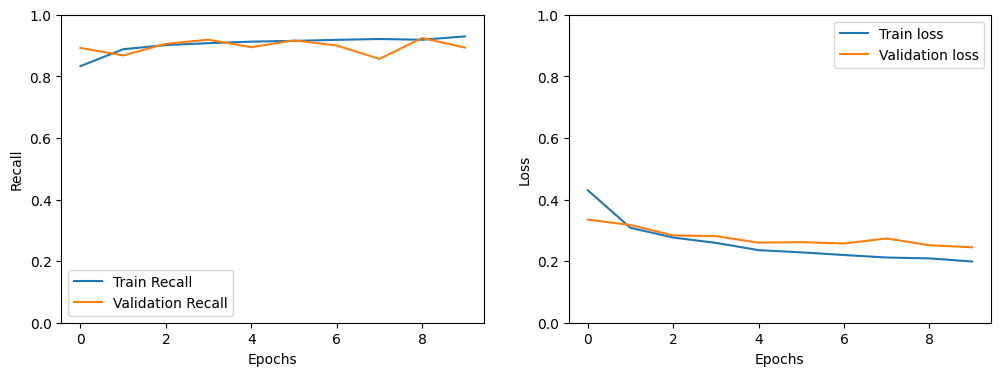

In [11]:
train_recall = history.history['recall']
val_recall = history.history['val_recall']

train_loss = history.history['loss']
val_loss = history.history['val_loss']


# Graficar las curvas de precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_recall, label='Train Recall')
plt.plot(val_recall, label='Validation Recall')
plt.ylim(0, 1)
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.ylim(0, 1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/My Drive/mi_modelo_VGG2.keras')


In [ ]:
modelo_cargado = load_model('/content/drive/My Drive/Colab Notebooks/VPC_2/mi_modelo_VGG.keras')

In [13]:
#Defino función de predicción
def prediccion(modelo,imagen,treshold):

     # Reshape para que coincida con el formato de entrada del modelo

      nueva_altura = 224
      nuevo_ancho = 224

      # Extraer caras con RetinaFace
      faces = RetinaFace.extract_faces(imagen, threshold=0.8)

      # Verificar si se detectó al menos una cara
      if len(faces) == 0:
        return "No se detectaron caras en la imagen"

      # Tomar la primera cara detectada (asumiendo que solo hay una)
      face = faces[0]

      h, w = face.shape[:2]


      # Calcular el nuevo tamaño manteniendo la relación de aspecto original
      factor_redimensionamiento = min(nueva_altura / h, nuevo_ancho / w)
      nueva_altura_temp = int(h * factor_redimensionamiento)
      nuevo_ancho_temp = int(w * factor_redimensionamiento)

      # Redimensionar la cara manteniendo la relación de aspecto
      cara_redimensionada = cv2.resize(face, (nuevo_ancho_temp, nueva_altura_temp))

      # Crear una imagen en blanco del tamaño objetivo
      imagen_final = np.zeros((nueva_altura, nuevo_ancho, 3), dtype=np.uint8)

      # Calcular las coordenadas para copiar la cara redimensionada en el centro
      y_offset = (nueva_altura - nueva_altura_temp) // 2
      x_offset = (nuevo_ancho - nuevo_ancho_temp) // 2

      # Copiar la región redimensionada en la ubicación calculada
      imagen_final[y_offset:y_offset + nueva_altura_temp, x_offset:x_offset + nuevo_ancho_temp] = cara_redimensionada

      imagen_final = tf.expand_dims(imagen_final, axis=0)


      # Realizar predicciones
      prediccion_imagen = modelo.predict(imagen_final)


      if prediccion_imagen > treshold:
            print(prediccion_imagen)
            return "La persona tiene sueño"
      else:
            print(prediccion_imagen)
            return "La persona no tiene sueño"


In [14]:
def face_detection(image,etiqueta):

    #Leo la imagen y detecto rostro
    faces = RetinaFace.detect_faces(image, threshold = 0.8)

    for face_key, face_info in faces.items():
        facial_area = face_info['facial_area']

    # Acceder a las coordenadas específicas
    x, y, width, height = facial_area

    # Dibujo el bounding box en la imagen original con la mejor coincidencia
    top_left = (x,y)
    bottom_right = (width, height)
    cv2.rectangle(image,(top_left),(bottom_right) , (0, 0, 255),2)

    final_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return  final_image

1/1 [==============================] - 0s 17ms/step
[[6.53133e-21]]


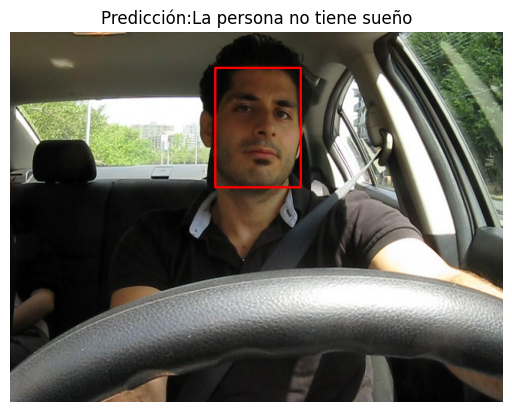

1/1 [==============================] - 0s 17ms/step
[[1.]]


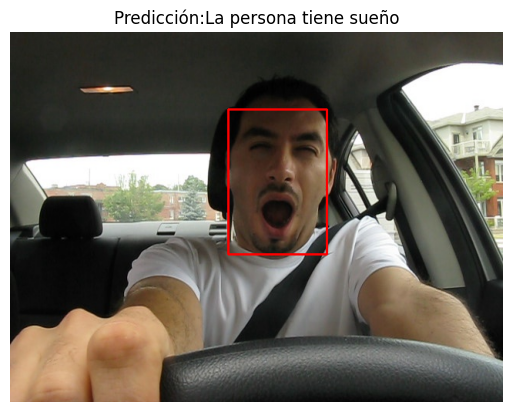

1/1 [==============================] - 0s 21ms/step
[[1.]]


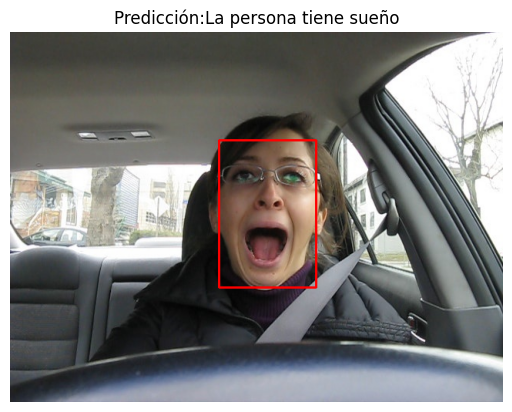

1/1 [==============================] - 0s 27ms/step
[[1.]]


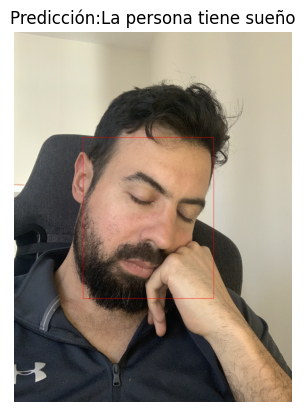

1/1 [==============================] - 0s 17ms/step
[[1.]]


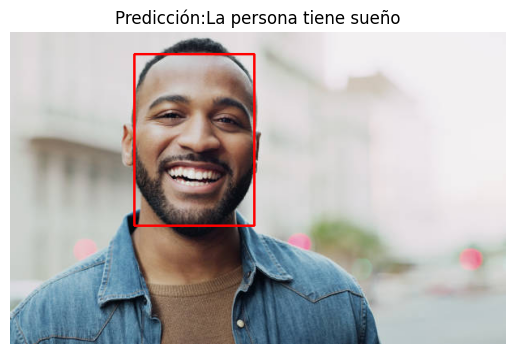

1/1 [==============================] - 0s 29ms/step
[[1.]]


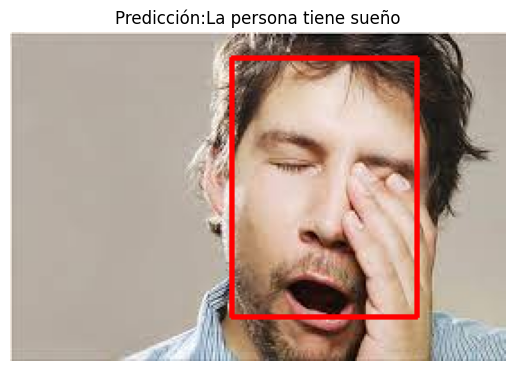

1/1 [==============================] - 0s 27ms/step
[[0.]]


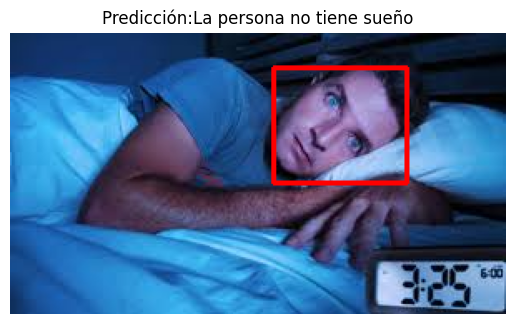

1/1 [==============================] - 0s 26ms/step
[[2.8833268e-30]]


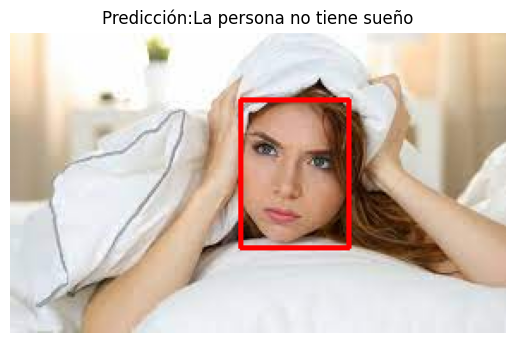

In [17]:
#Cargo imágenes a testear

# Directorio en Google Drive que contiene las imágenes
directorio_drive = '/content/drive/My Drive/Imágenes de prueba/Con sueño'

# Obtener la lista de nombres de archivos en el directorio
nombres_archivos = os.listdir(directorio_drive)

# Filtrar solo los archivos de imagen (puedes ajustar según los tipos de archivos que tengas)
extensiones_imagen = ['.jpg', '.jpeg', '.png']
rutas_imagenes = [os.path.join(directorio_drive, archivo) for archivo in nombres_archivos if any(archivo.lower().endswith(ext) for ext in extensiones_imagen)]

imagenes = [cv2.imread(ruta) for ruta in rutas_imagenes]

#Realizo predicciones
for imagen, ruta in zip(imagenes, rutas_imagenes):
    # Realizar la predicción
    pred = prediccion(model, imagen, 0.5)

    face = face_detection(imagen, pred)

    # Mostrar la imagen con el resultado de la predicción
    plt.imshow(face)
    plt.title(f"Predicción:{pred}")
    plt.axis('off')
    plt.show()